In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, roc_curve
from tensorflow.keras import layers
from statsmodels.tsa.ar_model import AutoReg

In [2]:
DATADIR = "/content/"
TRAIN_TEST_CUTOFF = '2016-04-21'
TRAIN_VALID_RATIO = 0.75

# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# to implement F1 score for validation in a batch
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

n_classes = 2

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes-1, activation="softmax")(x)
    return keras.Model(inputs, outputs)    


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def datagen(data, seq_len, batch_size, targetcol, kind, key):
    "As a generator to produce samples for Keras model"
    batch = []
    while True:
        # Pick one dataframe from the pool
        #key = random.choice(list(data.keys()))
        df = data[key]
        input_cols = [c for c in df.columns if c != targetcol]
        index = df.index[df.index < TRAIN_TEST_CUTOFF]
        split = int(len(index) * TRAIN_VALID_RATIO)
        assert split > seq_len, "Training data too small for sequence length {}".format(seq_len)
        if kind == 'train':
            index = index[:split]   # range for the training set
        elif kind == 'valid':
            index = index[split:]   # range for the validation set
        else:
            raise NotImplementedError
        # Pick one position, then clip a sequence length
        while True:
            t = random.choice(index)     # pick one time step
            n = (df.index == t).argmax() # find its position in the dataframe
            if n-seq_len+1 < 0:
                continue # this sample is not enough for one sequence length
            frame = df.iloc[n-seq_len+1:n+1]
            batch.append([frame[input_cols].values, df.loc[t, targetcol]])
            break
        # if we get enough for a batch, dispatch
        if len(batch) == batch_size:
            X, y = zip(*batch)
            X, y = np.expand_dims(np.array(X), 3), np.array(y)
            yield X.reshape((X.shape[0],X.shape[1],82)), y.astype(np.float)
            batch = []

def testgen(data, seq_len, targetcol,key):
    "Return array of all test samples"
    batch = []
    df = data[key]
    #for key, df in data.items():
    input_cols = [c for c in df.columns if c != targetcol]
    # find the start of test sample
    t = df.index[df.index >= TRAIN_TEST_CUTOFF][0]
    n = (df.index == t).argmax()
    # extract sample using a sliding window
    for i in range(n+1, len(df)+1):
        frame = df.iloc[i-seq_len:i]
        batch.append([frame[input_cols].values, frame[targetcol][-1]])
    X, y = zip(*batch)
    #return np.expand_dims(np.array(X),3), np.array(y)
    X, y = np.expand_dims(np.array(X), 3), np.array(y)
    #print(X.shape)
    return X.reshape((X.shape[0],X.shape[1],82)), y.astype(np.float)

# Read data into pandas DataFrames
data = {}
for filename in os.listdir('/content/'):
    if not filename.lower().endswith(".csv"):
        continue # read only the CSV files
    filepath = os.path.join('/content/', filename)
    X = pd.read_csv(filepath, index_col="Date", parse_dates=True)
    # basic preprocessing: get the name, the classification
    # Save the target variable as a column in dataframe for easier dropna()
    name = X["Name"][0]
    del X["Name"]
    cols = X.columns
    X["Target"] = (X["Close"].pct_change().shift(-1) > 0).astype(int)
    X.dropna(inplace=True)
    # Fit the standard scaler using the training dataset
    index = X.index[X.index < TRAIN_TEST_CUTOFF]
    index = index[:int(len(index) * TRAIN_VALID_RATIO)]
    scaler = StandardScaler().fit(X.loc[index, cols])
    # Save scale transformed dataframe
    X[cols] = scaler.transform(X[cols])
    data[name] = X

# I will start with 60 days
seq_len = 60
batch_size = 128
n_epochs = 5
n_features = 82



# Set up callbacks and fit the model
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
]
# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target",'S&P')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [3]:
input_shape = test_data.shape[1:]
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [4]:
# Define AUC
Aucroc = tf.keras.metrics.AUC(curve="ROC")
model.compile(
    loss=root_mean_squared_error, metrics=["acc", Aucroc, f1macro],
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 82)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 60, 82)      164         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 60, 82)      339026      ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

# For S&P

## For 60 Days

In [5]:
history = model.fit(
    datagen(data, seq_len, batch_size, "Target", "train",'S&P'),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid",'S&P'),
   epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target", 'S&P')

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("MAE:", mean_absolute_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))
fpr, tpr, thresholds = metrics.roc_curve(test_target,test_pred, pos_label=1)
print("Area under Curve: ",metrics.auc(fpr, tpr))

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 75s 158ms/step - loss: 0.6533 - acc: 0.5721 - auc: 0.5000 - f1macro: 0.3634 - val_loss: 0.7113 - val_acc: 0.4930 - val_auc: 0.5000 - val_f1macro: 0.3295
Epoch 2/5
400/400 [==============================] - 61s 153ms/step - loss: 0.6467 - acc: 0.5806 - auc: 0.5000 - f1macro: 0.3669 - val_loss: 0.7012 - val_acc: 0.5078 - val_auc: 0.5000 - val_f1macro: 0.3365
Epoch 3/5
400/400 [==============================] - 62s 154ms/step - loss: 0.6503 - acc: 0.5760 - auc: 0.5000 - f1macro: 0.3650 - val_loss: 0.6782 - val_acc: 0.5391 - val_auc: 0.5000 - val_f1macro: 0.3498
Epoch 4/5
400/400 [==============================] - 62s 155ms/step - loss: 0.6531 - acc: 0.5724 - auc: 0.5000 - f1macro: 0.3635 - val_loss: 0.7270 - val_acc: 0.4703 - val_auc: 0.5000 - val_f1macro: 0.3191
Epoch 5/5
400/400 [==============================] - 61s 152ms/step - loss: 0.6482 - acc: 0.5787 - auc: 0.5000 - f1macro: 0.3661 - val_loss: 0.7123 - val_acc: 0.4914 - val_auc: 0.5000 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


7/7 [==============================] - 1s 16ms/step
accuracy: 0.5073170731707317
MAE: 0.4926829268292683
F1: 0.6731391585760518
Area under Curve:  0.5


In [6]:
def plot_loss(train_loss,val_loss):
  loss_train = history.history[train_loss]
  loss_val = history.history[val_loss]
  plt.plot(loss_train, 'g', label='Training Loss')
  plt.plot(loss_val, 'b', label='validation Loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [7]:
def plot_accuracy(acc_train,acc_val):
  acc_train = history.history[acc_train]
  acc_val = history.history[acc_val]
  plt.plot(acc_train, 'g', label='Training Accuracy')
  plt.plot(acc_val, 'b', label='validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [8]:
def plot_f1macro(f1_train,f1_val):
  f1_train = history.history[f1_train]
  f1_val = history.history[f1_val]
  plt.plot(f1_train, 'g', label='Training F1macro')
  plt.plot(f1_val, 'b', label='validation F1macro')
  plt.title('Training and Validation F1macro')
  plt.xlabel('Epochs')
  plt.ylabel('F1macro')
  plt.legend()
  plt.show()

In [9]:
def plot_Aucroc():
  aucroc_train = history.history[list(history.history.keys())[2]]
  aucroc_val = history.history[list(history.history.keys())[6]]
  plt.plot(aucroc_train, 'g', label='Training AucRoc')
  plt.plot(aucroc_val, 'b', label='validation AucRoc')
  plt.title('Training and Validation AucRoc')
  plt.xlabel('Epochs')
  plt.ylabel('AUC')
  plt.legend()
  plt.show()

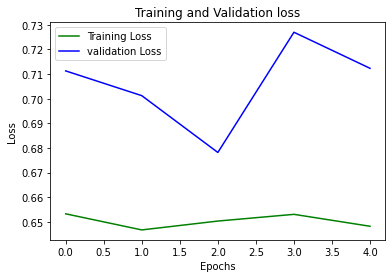

In [10]:
plot_loss('loss','val_loss')

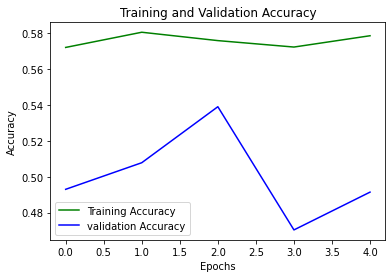

In [11]:
plot_accuracy('acc','val_acc')

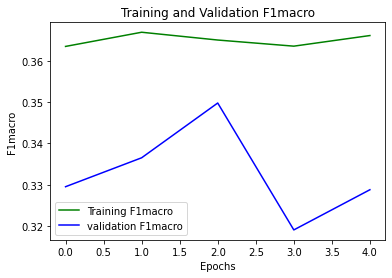

In [12]:
plot_f1macro('f1macro','val_f1macro')

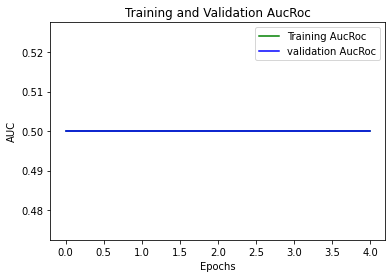

In [13]:
plot_Aucroc()

In [14]:
def model_transformer(key,seq_len, batch_size, n_epochs):
  # Set up callbacks and fit the model
  # We use custom validation score f1macro() and hence monitor for "val_f1macro"
  checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
  callbacks = [
      ModelCheckpoint(checkpoint_path,
                      monitor='val_f1macro', mode="max",
                      verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch")
  ]
  # Prepare test data
  test_data, test_target = testgen(data, seq_len, "Target",'S&P')
  input_shape = test_data.shape[1:]
  model = build_model(
      input_shape,
      head_size=256,
      num_heads=4,
      ff_dim=4,
      num_transformer_blocks=4,
      mlp_units=[128],
      mlp_dropout=0.4,
      dropout=0.25,
  )
  # Define AUC
  Aucroc = tf.keras.metrics.AUC(curve="PR")
  model.compile(
      loss=root_mean_squared_error, metrics=["acc", Aucroc, f1macro],
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
  )
  #model.summary()
  history = model.fit(
      datagen(data, seq_len, batch_size, "Target", "train",key),
            validation_data=datagen(data, seq_len, batch_size, "Target", "valid",key),
    epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks
  )

  # Prepare test data
  test_data, test_target = testgen(data, seq_len, "Target", key)

  # Test the model
  test_out = model.predict(test_data)
  test_pred = (test_out > 0.5).astype(int)
  print("accuracy:", accuracy_score(test_pred, test_target))
  print("MAE:", mean_absolute_error(test_pred, test_target))
  print("F1:", f1_score(test_pred, test_target))
  fpr, tpr, thresholds = metrics.roc_curve(test_target,test_pred, pos_label=1)
  print("Area under Curve: ",metrics.auc(fpr, tpr))

  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  plt.plot(loss_train, 'g', label='Training Loss')
  plt.plot(loss_val, 'b', label='validation Loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  ##

  acc_train = history.history['acc']
  acc_val = history.history['val_acc']
  plt.plot(acc_train, 'g', label='Training Accuracy')
  plt.plot(acc_val, 'b', label='validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  ##

  f1_train = history.history['f1macro']
  f1_val = history.history['val_f1macro']
  plt.plot(f1_train, 'g', label='Training F1macro')
  plt.plot(f1_val, 'b', label='validation F1macro')
  plt.title('Training and Validation F1macro')
  plt.xlabel('Epochs')
  plt.ylabel('F1macro')
  plt.legend()
  plt.show()

  ##

  aucroc_train = history.history[list(history.history.keys())[2]]
  aucroc_val = history.history[list(history.history.keys())[6]]
  plt.plot(aucroc_train, 'g', label='Training AucRoc')
  plt.plot(aucroc_val, 'b', label='validation AucRoc')
  plt.title('Training and Validation AucRoc')
  plt.xlabel('Epochs')
  plt.ylabel('AUC')
  plt.legend()
  plt.show()


## For 30 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 63s 146ms/step - loss: 0.6465 - acc: 0.5807 - auc_1: 0.5807 - f1macro: 0.3668 - val_loss: 0.7186 - val_acc: 0.4820 - val_auc_1: 0.4820 - val_f1macro: 0.3244
Epoch 2/5
400/400 [==============================] - 58s 146ms/step - loss: 0.6484 - acc: 0.5783 - auc_1: 0.5783 - f1macro: 0.3658 - val_loss: 0.6951 - val_acc: 0.5156 - val_auc_1: 0.5156 - val_f1macro: 0.3396
Epoch 3/5
400/400 [==============================] - 57s 143ms/step - loss: 0.6469 - acc: 0.5804 - auc_1: 0.5804 - f1macro: 0.3668 - val_loss: 0.7054 - val_acc: 0.5016 - val_auc_1: 0.5016 - val_f1macro: 0.3335
Epoch 4/5
400/400 [==============================] - 57s 143ms/step - loss: 0.6423 - acc: 0.5863 - auc_1: 0.5863 - f1macro: 0.3691 - val_loss: 0.7312 - val_acc: 0.4648 - val_auc_1: 0.4648 - val_f1macro: 0.3170
Epoch 5/5
7/7 [==============================] - 0s 11ms/step
accuracy: 0.5073170731707317
MAE: 0.4926829268292683
F1: 0.6731391585760518
Area under Curve:  0.5


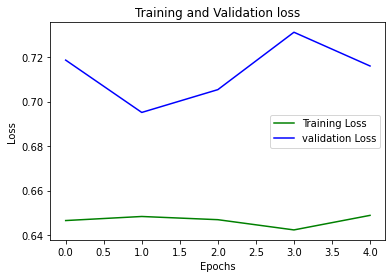

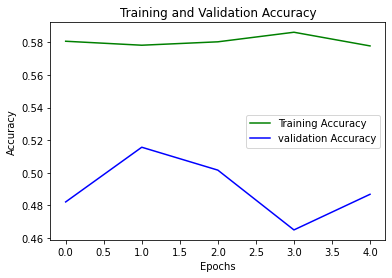

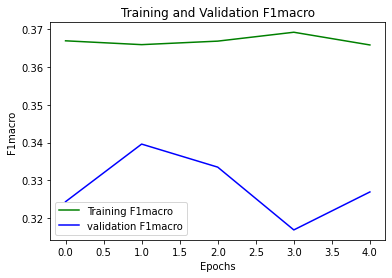

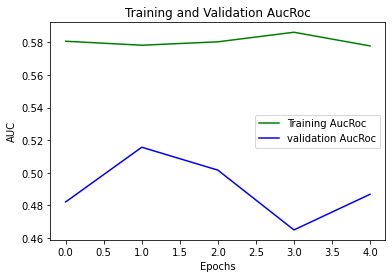

In [15]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5

model_transformer('S&P', seq_len, batch_size, n_epochs)

## For 20 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 62s 145ms/step - loss: 0.6488 - acc: 0.5778 - auc_2: 0.5778 - f1macro: 0.3657 - val_loss: 0.7012 - val_acc: 0.5078 - val_auc_2: 0.5078 - val_f1macro: 0.3365
Epoch 2/5
400/400 [==============================] - 56s 141ms/step - loss: 0.6524 - acc: 0.5732 - auc_2: 0.5732 - f1macro: 0.3639 - val_loss: 0.7182 - val_acc: 0.4836 - val_auc_2: 0.4836 - val_f1macro: 0.3256
Epoch 3/5
400/400 [==============================] - 57s 143ms/step - loss: 0.6496 - acc: 0.5770 - auc_2: 0.5770 - f1macro: 0.3654 - val_loss: 0.7114 - val_acc: 0.4930 - val_auc_2: 0.4930 - val_f1macro: 0.3296
Epoch 4/5
400/400 [==============================] - 56s 141ms/step - loss: 0.6485 - acc: 0.5784 - auc_2: 0.5784 - f1macro: 0.3660 - val_loss: 0.7110 - val_acc: 0.4938 - val_auc_2: 0.4938 - val_f1macro: 0.3301
Epoch 5/5
7/7 [==============================] - 0s 11ms/step
accuracy: 0.5073170731707317
MAE: 0.4926829268292683
F1: 0.6731391585760518
Area under Curve:  0.5


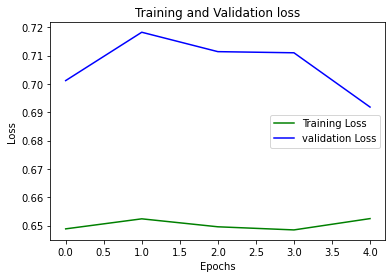

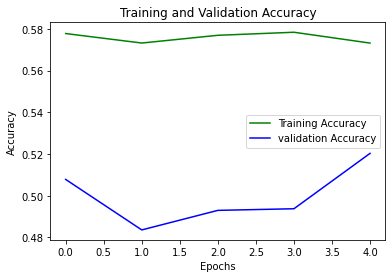

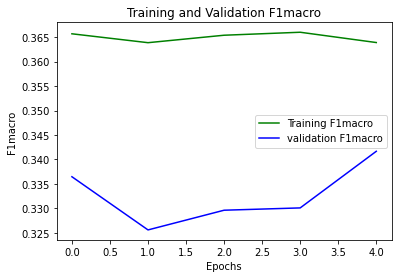

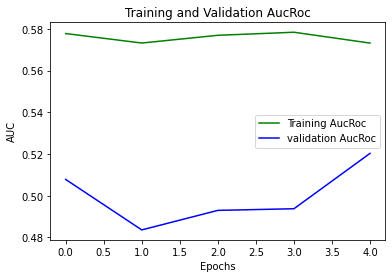

In [16]:
# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5

model_transformer('S&P', seq_len, batch_size, n_epochs)

## For 10 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 60s 139ms/step - loss: 0.6494 - acc: 0.5771 - auc_3: 0.5771 - f1macro: 0.3654 - val_loss: 0.7132 - val_acc: 0.4906 - val_auc_3: 0.4906 - val_f1macro: 0.3287
Epoch 2/5
400/400 [==============================] - 55s 137ms/step - loss: 0.6504 - acc: 0.5758 - auc_3: 0.5758 - f1macro: 0.3649 - val_loss: 0.6990 - val_acc: 0.5109 - val_auc_3: 0.5109 - val_f1macro: 0.3379
Epoch 3/5
400/400 [==============================] - 55s 137ms/step - loss: 0.6531 - acc: 0.5725 - auc_3: 0.5725 - f1macro: 0.3636 - val_loss: 0.7073 - val_acc: 0.4984 - val_auc_3: 0.4984 - val_f1macro: 0.3318
Epoch 4/5
400/400 [==============================] - 56s 140ms/step - loss: 0.6526 - acc: 0.5729 - auc_3: 0.5729 - f1macro: 0.3637 - val_loss: 0.7241 - val_acc: 0.4750 - val_auc_3: 0.4750 - val_f1macro: 0.3216
Epoch 5/5
7/7 [==============================] - 0s 11ms/step
accuracy: 0.5073170731707317
MAE: 0.4926829268292683
F1: 0.6731391585760518
Area under Curve:  0.5


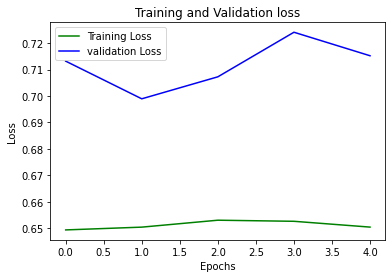

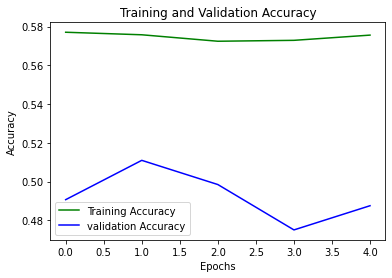

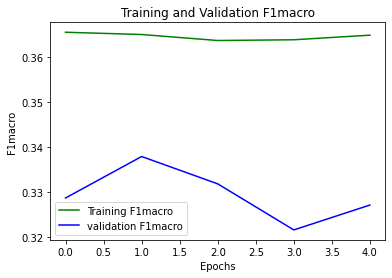

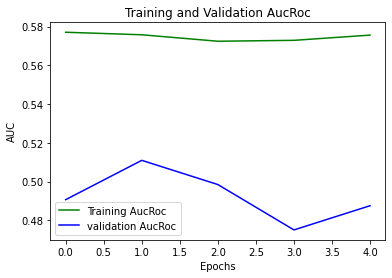

In [17]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5

model_transformer('S&P', seq_len, batch_size, n_epochs)

# For NYA

## For 60 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 66s 153ms/step - loss: 0.6641 - acc: 0.5580 - auc_4: 0.5580 - f1macro: 0.3577 - val_loss: 0.7000 - val_acc: 0.5094 - val_auc_4: 0.5094 - val_f1macro: 0.3371
Epoch 2/5
400/400 [==============================] - 61s 154ms/step - loss: 0.6635 - acc: 0.5587 - auc_4: 0.5587 - f1macro: 0.3580 - val_loss: 0.6990 - val_acc: 0.5109 - val_auc_4: 0.5109 - val_f1macro: 0.3379
Epoch 3/5
400/400 [==============================] - 61s 152ms/step - loss: 0.6628 - acc: 0.5595 - auc_4: 0.5595 - f1macro: 0.3582 - val_loss: 0.7232 - val_acc: 0.4766 - val_auc_4: 0.4766 - val_f1macro: 0.3225
Epoch 4/5
400/400 [==============================] - 61s 153ms/step - loss: 0.6634 - acc: 0.5588 - auc_4: 0.5588 - f1macro: 0.3579 - val_loss: 0.7016 - val_acc: 0.5070 - val_auc_4: 0.5070 - val_f1macro: 0.3360
Epoch 5/5
7/7 [==============================] - 0s 11ms/step
accuracy: 0.5317073170731708
MAE: 0.4682926829268293
F1: 0.694267515923567
Area under Curve:  0.5


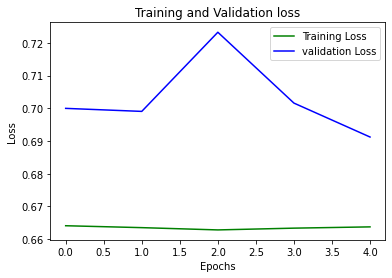

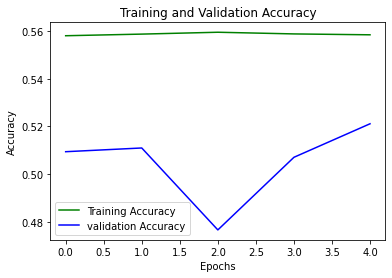

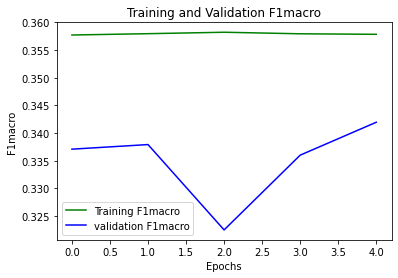

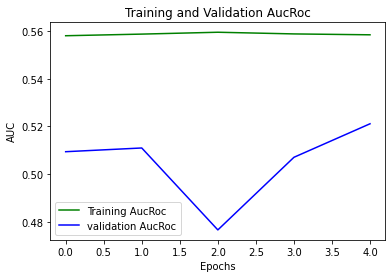

In [18]:
# For 60 days
seq_len = 60
batch_size = 128
n_epochs = 5

model_transformer('NYA', seq_len, batch_size, n_epochs)

## For 30 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 62s 145ms/step - loss: 0.6611 - acc: 0.5618 - auc_5: 0.5618 - f1macro: 0.3592 - val_loss: 0.6857 - val_acc: 0.5289 - val_auc_5: 0.5289 - val_f1macro: 0.3455
Epoch 2/5
400/400 [==============================] - 59s 147ms/step - loss: 0.6637 - acc: 0.5584 - auc_5: 0.5584 - f1macro: 0.3578 - val_loss: 0.7101 - val_acc: 0.4945 - val_auc_5: 0.4945 - val_f1macro: 0.3301
Epoch 3/5
400/400 [==============================] - 58s 145ms/step - loss: 0.6673 - acc: 0.5536 - auc_5: 0.5536 - f1macro: 0.3558 - val_loss: 0.7171 - val_acc: 0.4852 - val_auc_5: 0.4852 - val_f1macro: 0.3262
Epoch 4/5
400/400 [==============================] - 57s 142ms/step - loss: 0.6648 - acc: 0.5569 - auc_5: 0.5569 - f1macro: 0.3572 - val_loss: 0.7093 - val_acc: 0.4961 - val_auc_5: 0.4961 - val_f1macro: 0.3311
Epoch 5/5
7/7 [==============================] - 0s 7ms/step
accuracy: 0.5317073170731708
MAE: 0.4682926829268293
F1: 0.694267515923567
Area under Curve:  0.5


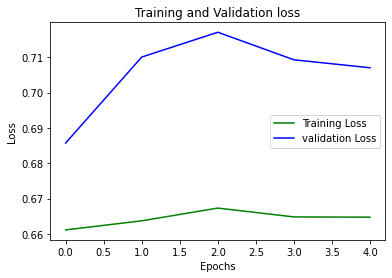

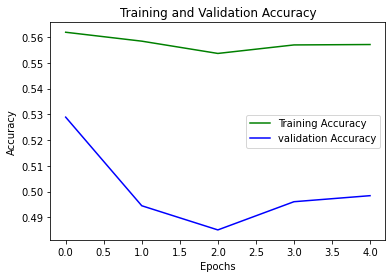

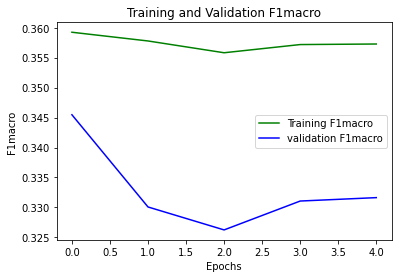

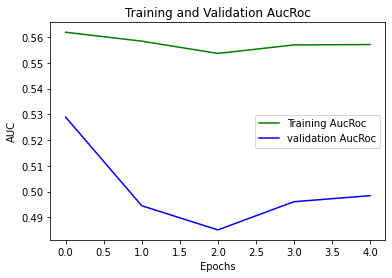

In [19]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5

model_transformer('NYA', seq_len, batch_size, n_epochs)

## For 20 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 62s 144ms/step - loss: 0.6688 - acc: 0.5517 - auc_6: 0.5517 - f1macro: 0.3551 - val_loss: 0.7073 - val_acc: 0.4992 - val_auc_6: 0.4992 - val_f1macro: 0.3327
Epoch 2/5
400/400 [==============================] - 56s 140ms/step - loss: 0.6644 - acc: 0.5574 - auc_6: 0.5574 - f1macro: 0.3574 - val_loss: 0.6973 - val_acc: 0.5133 - val_auc_6: 0.5133 - val_f1macro: 0.3389
Epoch 3/5
400/400 [==============================] - 57s 144ms/step - loss: 0.6653 - acc: 0.5562 - auc_6: 0.5562 - f1macro: 0.3569 - val_loss: 0.7191 - val_acc: 0.4812 - val_auc_6: 0.4812 - val_f1macro: 0.3238
Epoch 4/5
400/400 [==============================] - 56s 141ms/step - loss: 0.6643 - acc: 0.5576 - auc_6: 0.5576 - f1macro: 0.3575 - val_loss: 0.6916 - val_acc: 0.5203 - val_auc_6: 0.5203 - val_f1macro: 0.3415
Epoch 5/5
7/7 [==============================] - 0s 6ms/step
accuracy: 0.5317073170731708
MAE: 0.4682926829268293
F1: 0.694267515923567
Area under Curve:  0.5


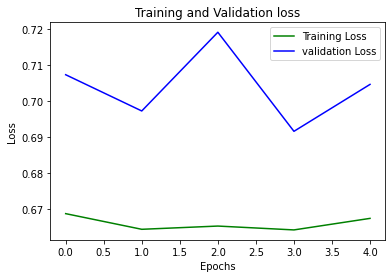

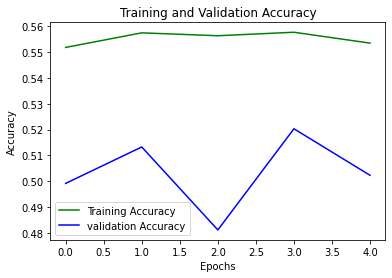

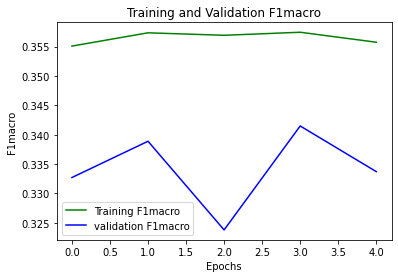

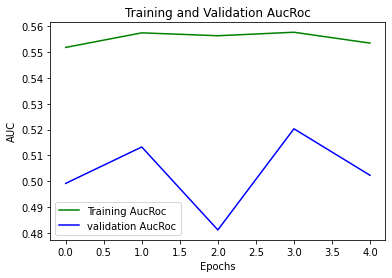

In [20]:
# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5

model_transformer('NYA', seq_len, batch_size, n_epochs)

## For 10 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 60s 139ms/step - loss: 0.6669 - acc: 0.5540 - auc_7: 0.5540 - f1macro: 0.3560 - val_loss: 0.6858 - val_acc: 0.5289 - val_auc_7: 0.5289 - val_f1macro: 0.3455
Epoch 2/5
400/400 [==============================] - 55s 137ms/step - loss: 0.6653 - acc: 0.5563 - auc_7: 0.5563 - f1macro: 0.3570 - val_loss: 0.6886 - val_acc: 0.5242 - val_auc_7: 0.5242 - val_f1macro: 0.3430
Epoch 3/5
400/400 [==============================] - 55s 137ms/step - loss: 0.6692 - acc: 0.5512 - auc_7: 0.5512 - f1macro: 0.3549 - val_loss: 0.6951 - val_acc: 0.5164 - val_auc_7: 0.5164 - val_f1macro: 0.3403
Epoch 4/5
400/400 [==============================] - 57s 142ms/step - loss: 0.6671 - acc: 0.5537 - auc_7: 0.5537 - f1macro: 0.3558 - val_loss: 0.7059 - val_acc: 0.5000 - val_auc_7: 0.5000 - val_f1macro: 0.3324
Epoch 5/5
7/7 [==============================] - 0s 5ms/step
accuracy: 0.5317073170731708
MAE: 0.4682926829268293
F1: 0.694267515923567
Area under Curve:  0.5


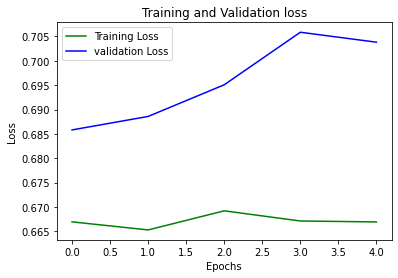

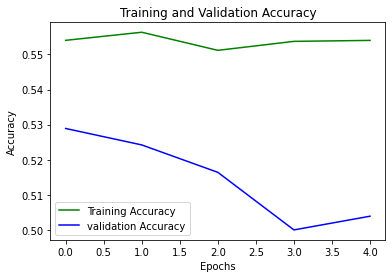

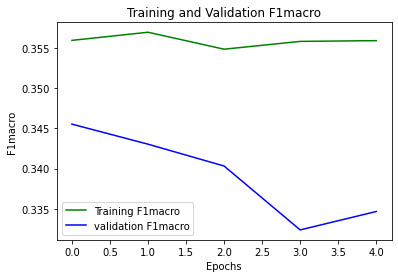

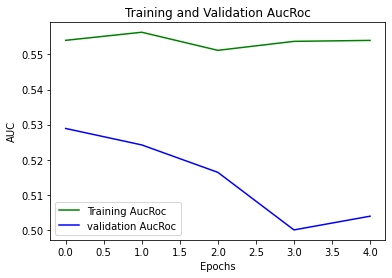

In [21]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5

model_transformer('NYA', seq_len, batch_size, n_epochs)

# For DJI

## For 60 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 66s 156ms/step - loss: 0.6677 - acc: 0.5530 - auc_8: 0.5530 - f1macro: 0.3555 - val_loss: 0.7072 - val_acc: 0.4984 - val_auc_8: 0.4984 - val_f1macro: 0.3318
Epoch 2/5
400/400 [==============================] - 62s 154ms/step - loss: 0.6673 - acc: 0.5536 - auc_8: 0.5536 - f1macro: 0.3558 - val_loss: 0.7098 - val_acc: 0.4953 - val_auc_8: 0.4953 - val_f1macro: 0.3307
Epoch 3/5
400/400 [==============================] - 76s 190ms/step - loss: 0.6672 - acc: 0.5536 - auc_8: 0.5536 - f1macro: 0.3558 - val_loss: 0.6912 - val_acc: 0.5211 - val_auc_8: 0.5211 - val_f1macro: 0.3419
Epoch 4/5
400/400 [==============================] - 76s 191ms/step - loss: 0.6659 - acc: 0.5553 - auc_8: 0.5553 - f1macro: 0.3565 - val_loss: 0.6913 - val_acc: 0.5211 - val_auc_8: 0.5211 - val_f1macro: 0.3420
Epoch 5/5
7/7 [==============================] - 0s 10ms/step
accuracy: 0.5414634146341464
MAE: 0.4585365853658537
F1: 0.7025316455696203
Area under Curve:  0.5


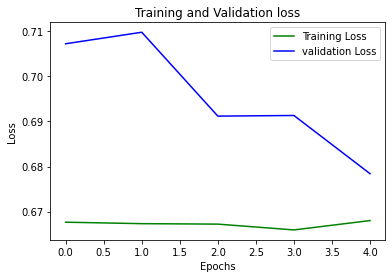

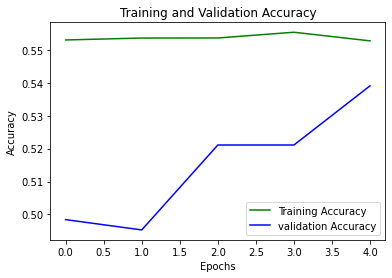

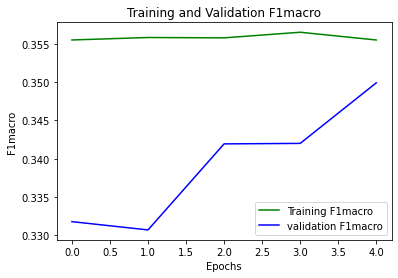

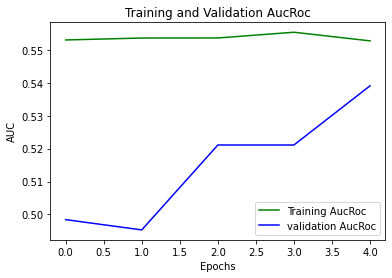

In [22]:
# For 60 days
seq_len = 60
batch_size = 128
n_epochs = 5

model_transformer('DJI', seq_len, batch_size, n_epochs)

## For 30 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 63s 145ms/step - loss: 0.6624 - acc: 0.5601 - auc_9: 0.5601 - f1macro: 0.3585 - val_loss: 0.7043 - val_acc: 0.5031 - val_auc_9: 0.5031 - val_f1macro: 0.3343
Epoch 2/5
400/400 [==============================] - 57s 144ms/step - loss: 0.6653 - acc: 0.5562 - auc_9: 0.5562 - f1macro: 0.3569 - val_loss: 0.7039 - val_acc: 0.5039 - val_auc_9: 0.5039 - val_f1macro: 0.3347
Epoch 3/5
400/400 [==============================] - 58s 145ms/step - loss: 0.6684 - acc: 0.5521 - auc_9: 0.5521 - f1macro: 0.3552 - val_loss: 0.6819 - val_acc: 0.5344 - val_auc_9: 0.5344 - val_f1macro: 0.3480
Epoch 4/5
400/400 [==============================] - 56s 141ms/step - loss: 0.6699 - acc: 0.5503 - auc_9: 0.5503 - f1macro: 0.3545 - val_loss: 0.7164 - val_acc: 0.4859 - val_auc_9: 0.4859 - val_f1macro: 0.3265
Epoch 5/5
7/7 [==============================] - 1s 7ms/step
accuracy: 0.5414634146341464
MAE: 0.4585365853658537
F1: 0.7025316455696203
Area under Curve:  0.5


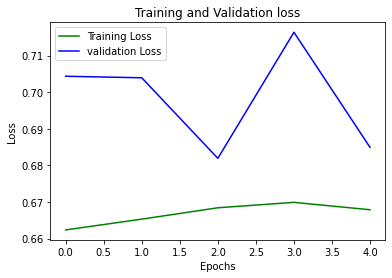

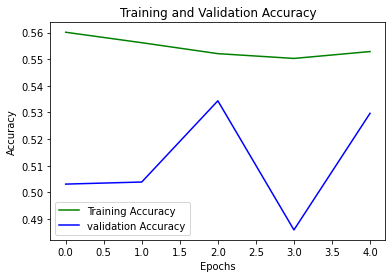

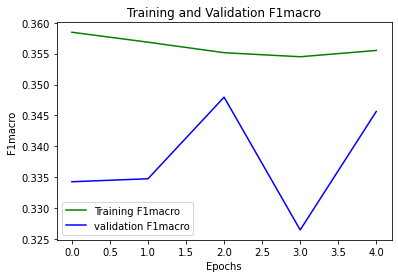

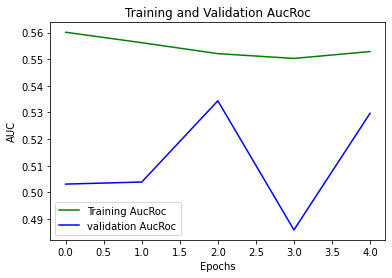

In [24]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5

model_transformer('DJI', seq_len, batch_size, n_epochs)

# For 20 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 60s 140ms/step - loss: 0.6726 - acc: 0.5465 - auc_10: 0.5465 - f1macro: 0.3529 - val_loss: 0.6958 - val_acc: 0.5141 - val_auc_10: 0.5141 - val_f1macro: 0.3385
Epoch 2/5
400/400 [==============================] - 56s 139ms/step - loss: 0.6695 - acc: 0.5507 - auc_10: 0.5507 - f1macro: 0.3546 - val_loss: 0.6852 - val_acc: 0.5297 - val_auc_10: 0.5297 - val_f1macro: 0.3459
Epoch 3/5
400/400 [==============================] - 55s 138ms/step - loss: 0.6690 - acc: 0.5514 - auc_10: 0.5514 - f1macro: 0.3549 - val_loss: 0.6884 - val_acc: 0.5250 - val_auc_10: 0.5250 - val_f1macro: 0.3437
Epoch 4/5
400/400 [==============================] - 57s 143ms/step - loss: 0.6728 - acc: 0.5461 - auc_10: 0.5461 - f1macro: 0.3526 - val_loss: 0.7012 - val_acc: 0.5078 - val_auc_10: 0.5078 - val_f1macro: 0.3365
Epoch 5/5
7/7 [==============================] - 0s 6ms/step
accuracy: 0.5414634146341464
MAE: 0.4585365853658537
F1: 0.7025316455696203
Area under Curve:  0.5


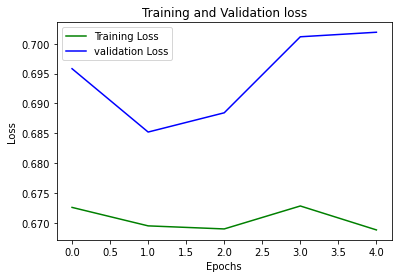

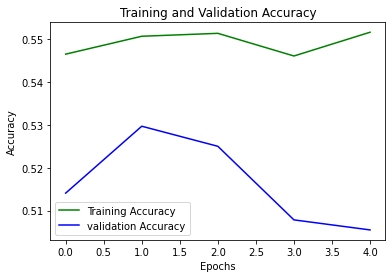

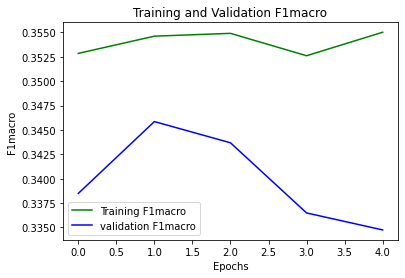

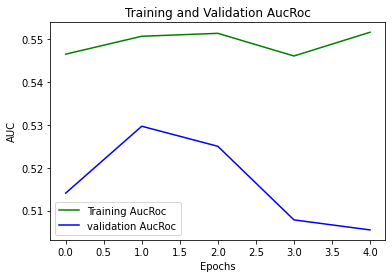

In [25]:
# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5

model_transformer('DJI', seq_len, batch_size, n_epochs)

## For 10 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 59s 137ms/step - loss: 0.6677 - acc: 0.5531 - auc_11: 0.5531 - f1macro: 0.3556 - val_loss: 0.7014 - val_acc: 0.5070 - val_auc_11: 0.5070 - val_f1macro: 0.3359
Epoch 2/5
400/400 [==============================] - 55s 137ms/step - loss: 0.6699 - acc: 0.5501 - auc_11: 0.5501 - f1macro: 0.3544 - val_loss: 0.7109 - val_acc: 0.4938 - val_auc_11: 0.4938 - val_f1macro: 0.3300
Epoch 3/5
400/400 [==============================] - 54s 135ms/step - loss: 0.6704 - acc: 0.5494 - auc_11: 0.5494 - f1macro: 0.3540 - val_loss: 0.7010 - val_acc: 0.5078 - val_auc_11: 0.5078 - val_f1macro: 0.3364
Epoch 4/5
400/400 [==============================] - 54s 135ms/step - loss: 0.6727 - acc: 0.5464 - auc_11: 0.5464 - f1macro: 0.3528 - val_loss: 0.7266 - val_acc: 0.4711 - val_auc_11: 0.4711 - val_f1macro: 0.3197
Epoch 5/5
7/7 [==============================] - 0s 6ms/step
accuracy: 0.5414634146341464
MAE: 0.4585365853658537
F1: 0.7025316455696203
Area under Curve:  0.5


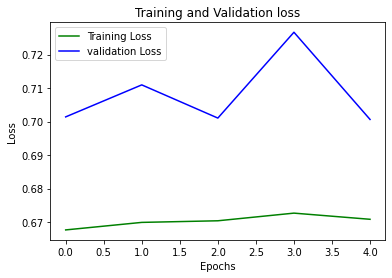

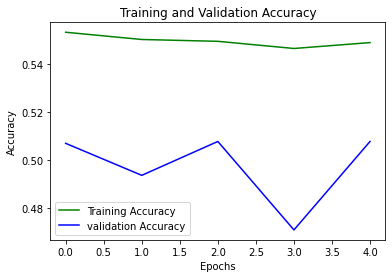

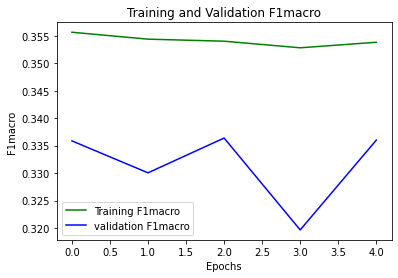

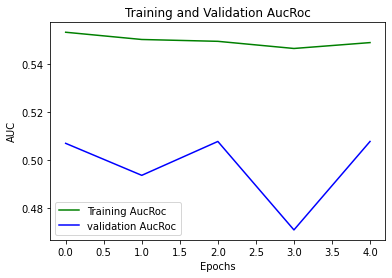

In [26]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5

model_transformer('DJI', seq_len, batch_size, n_epochs)

# For RUT

## For 60 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 65s 152ms/step - loss: 0.6761 - acc: 0.5419 - auc_12: 0.5419 - f1macro: 0.3509 - val_loss: 0.7019 - val_acc: 0.5063 - val_auc_12: 0.5063 - val_f1macro: 0.3355
Epoch 2/5
400/400 [==============================] - 60s 150ms/step - loss: 0.6727 - acc: 0.5465 - auc_12: 0.5465 - f1macro: 0.3529 - val_loss: 0.6871 - val_acc: 0.5273 - val_auc_12: 0.5273 - val_f1macro: 0.3450
Epoch 3/5
400/400 [==============================] - 61s 152ms/step - loss: 0.6759 - acc: 0.5421 - auc_12: 0.5421 - f1macro: 0.3511 - val_loss: 0.6774 - val_acc: 0.5398 - val_auc_12: 0.5398 - val_f1macro: 0.3499
Epoch 4/5
400/400 [==============================] - 60s 149ms/step - loss: 0.6738 - acc: 0.5449 - auc_12: 0.5449 - f1macro: 0.3522 - val_loss: 0.6819 - val_acc: 0.5344 - val_auc_12: 0.5344 - val_f1macro: 0.3480
Epoch 5/5
7/7 [==============================] - 0s 11ms/step
accuracy: 0.526829268292683
MAE: 0.47317073170731705
F1: 0.6900958466453674
Area under Curve:  0.5


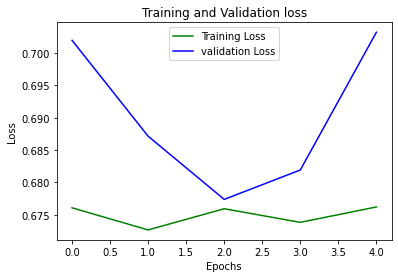

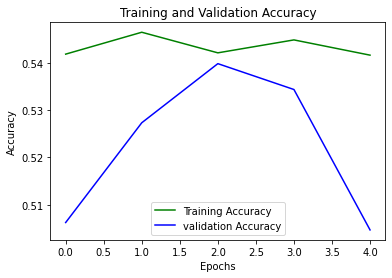

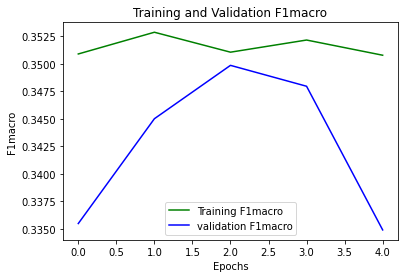

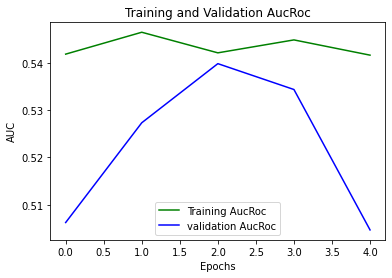

In [27]:
# For 60 days
seq_len = 60
batch_size = 128
n_epochs = 5

model_transformer('RUT', seq_len, batch_size, n_epochs)

## For 30 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 62s 144ms/step - loss: 0.6730 - acc: 0.5461 - auc_13: 0.5461 - f1macro: 0.3528 - val_loss: 0.6872 - val_acc: 0.5273 - val_auc_13: 0.5273 - val_f1macro: 0.3451
Epoch 2/5
400/400 [==============================] - 57s 143ms/step - loss: 0.6772 - acc: 0.5404 - auc_13: 0.5404 - f1macro: 0.3503 - val_loss: 0.6960 - val_acc: 0.5148 - val_auc_13: 0.5148 - val_f1macro: 0.3394
Epoch 3/5
400/400 [==============================] - 56s 140ms/step - loss: 0.6752 - acc: 0.5429 - auc_13: 0.5429 - f1macro: 0.3513 - val_loss: 0.6949 - val_acc: 0.5156 - val_auc_13: 0.5156 - val_f1macro: 0.3394
Epoch 4/5
400/400 [==============================] - 56s 139ms/step - loss: 0.6759 - acc: 0.5419 - auc_13: 0.5419 - f1macro: 0.3508 - val_loss: 0.6946 - val_acc: 0.5164 - val_auc_13: 0.5164 - val_f1macro: 0.3399
Epoch 5/5
7/7 [==============================] - 0s 7ms/step
accuracy: 0.526829268292683
MAE: 0.47317073170731705
F1: 0.6900958466453674
Area under Curve:  0.5


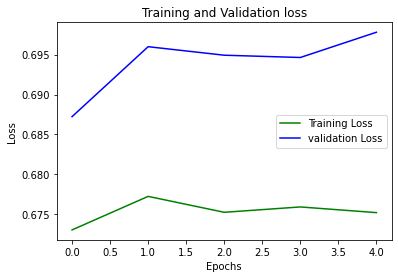

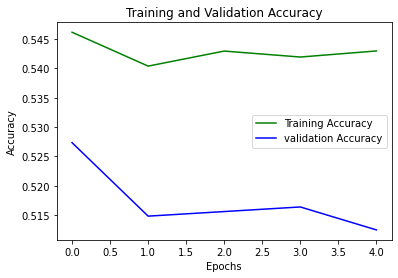

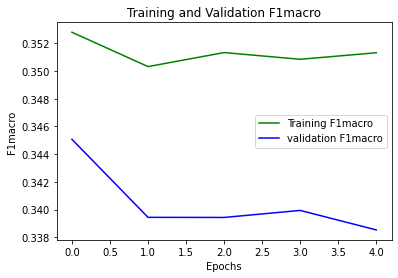

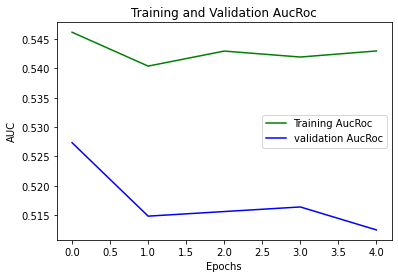

In [28]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5

model_transformer('RUT', seq_len, batch_size, n_epochs)

## For 20 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 60s 140ms/step - loss: 0.6753 - acc: 0.5429 - auc_14: 0.5429 - f1macro: 0.3514 - val_loss: 0.6750 - val_acc: 0.5430 - val_auc_14: 0.5430 - val_f1macro: 0.3512
Epoch 2/5
400/400 [==============================] - 56s 141ms/step - loss: 0.6773 - acc: 0.5401 - auc_14: 0.5401 - f1macro: 0.3501 - val_loss: 0.6866 - val_acc: 0.5281 - val_auc_14: 0.5281 - val_f1macro: 0.3454
Epoch 3/5
400/400 [==============================] - 56s 139ms/step - loss: 0.6773 - acc: 0.5402 - auc_14: 0.5402 - f1macro: 0.3502 - val_loss: 0.6671 - val_acc: 0.5539 - val_auc_14: 0.5539 - val_f1macro: 0.3560
Epoch 4/5
400/400 [==============================] - 55s 138ms/step - loss: 0.6762 - acc: 0.5416 - auc_14: 0.5416 - f1macro: 0.3507 - val_loss: 0.6914 - val_acc: 0.5211 - val_auc_14: 0.5211 - val_f1macro: 0.3421
Epoch 5/5
7/7 [==============================] - 0s 6ms/step
accuracy: 0.526829268292683
MAE: 0.47317073170731705
F1: 0.6900958466453674
Area under Curve:  0.5


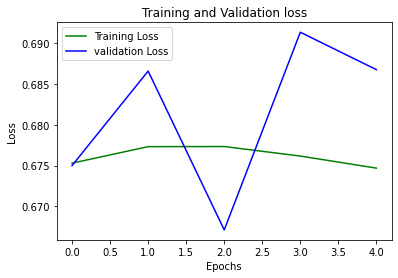

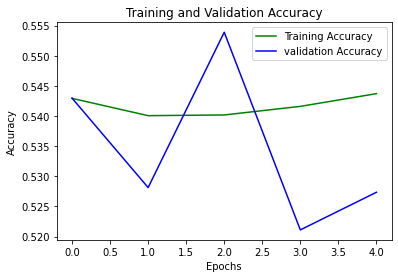

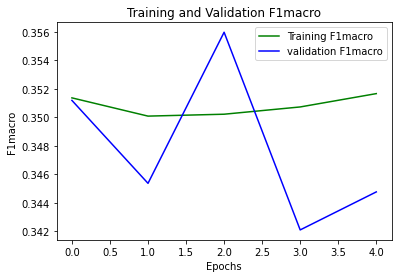

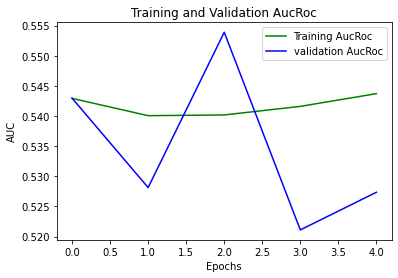

In [29]:
# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5

model_transformer('RUT', seq_len, batch_size, n_epochs)

## For 10 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 59s 138ms/step - loss: 0.6741 - acc: 0.5445 - auc_15: 0.5445 - f1macro: 0.3520 - val_loss: 0.7024 - val_acc: 0.5047 - val_auc_15: 0.5047 - val_f1macro: 0.3344
Epoch 2/5
400/400 [==============================] - 54s 135ms/step - loss: 0.6717 - acc: 0.5477 - auc_15: 0.5477 - f1macro: 0.3533 - val_loss: 0.6951 - val_acc: 0.5156 - val_auc_15: 0.5156 - val_f1macro: 0.3395
Epoch 3/5
400/400 [==============================] - 53s 134ms/step - loss: 0.6743 - acc: 0.5442 - auc_15: 0.5442 - f1macro: 0.3519 - val_loss: 0.6887 - val_acc: 0.5242 - val_auc_15: 0.5242 - val_f1macro: 0.3432
Epoch 4/5
400/400 [==============================] - 55s 138ms/step - loss: 0.6736 - acc: 0.5454 - auc_15: 0.5454 - f1macro: 0.3524 - val_loss: 0.6945 - val_acc: 0.5172 - val_auc_15: 0.5172 - val_f1macro: 0.3406
Epoch 5/5
7/7 [==============================] - 0s 5ms/step
accuracy: 0.526829268292683
MAE: 0.47317073170731705
F1: 0.6900958466453674
Area under Curve:  0.5


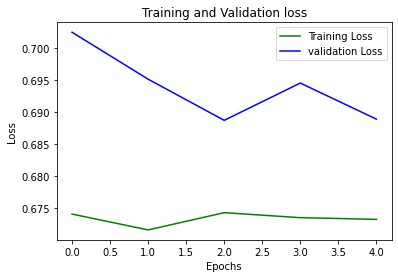

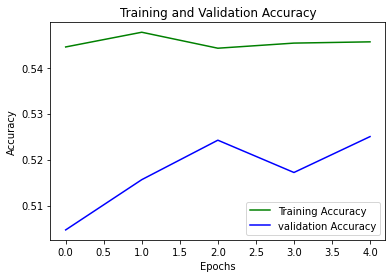

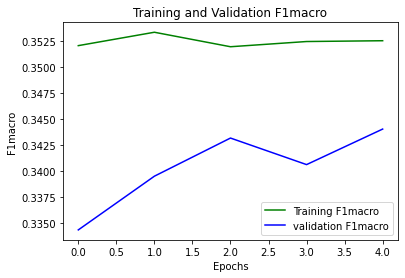

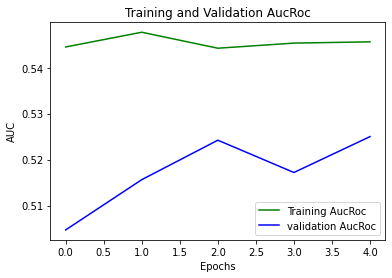

In [30]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5

model_transformer('RUT', seq_len, batch_size, n_epochs)

# For NASDAQ

## For 60 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 64s 151ms/step - loss: 0.6594 - acc: 0.5640 - auc_16: 0.5640 - f1macro: 0.3601 - val_loss: 0.6795 - val_acc: 0.5375 - val_auc_16: 0.5375 - val_f1macro: 0.3492
Epoch 2/5
400/400 [==============================] - 62s 156ms/step - loss: 0.6564 - acc: 0.5680 - auc_16: 0.5680 - f1macro: 0.3617 - val_loss: 0.6923 - val_acc: 0.5203 - val_auc_16: 0.5203 - val_f1macro: 0.3420
Epoch 3/5
400/400 [==============================] - 60s 149ms/step - loss: 0.6595 - acc: 0.5639 - auc_16: 0.5639 - f1macro: 0.3600 - val_loss: 0.6984 - val_acc: 0.5109 - val_auc_16: 0.5109 - val_f1macro: 0.3374
Epoch 4/5
400/400 [==============================] - 60s 149ms/step - loss: 0.6553 - acc: 0.5695 - auc_16: 0.5695 - f1macro: 0.3624 - val_loss: 0.6807 - val_acc: 0.5344 - val_auc_16: 0.5344 - val_f1macro: 0.3472
Epoch 5/5
7/7 [==============================] - 0s 10ms/step
accuracy: 0.5804878048780487
MAE: 0.4195121951219512
F1: 0.7345679012345678
Area under Curve:  0.5


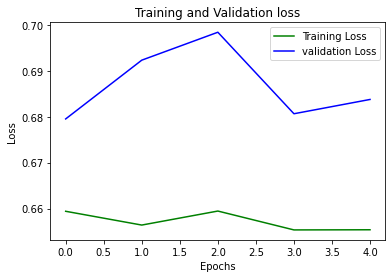

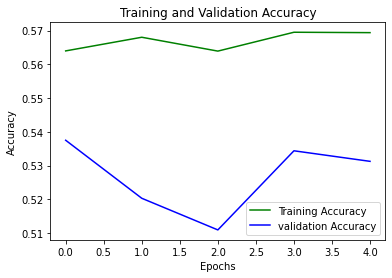

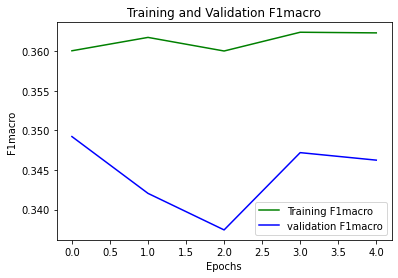

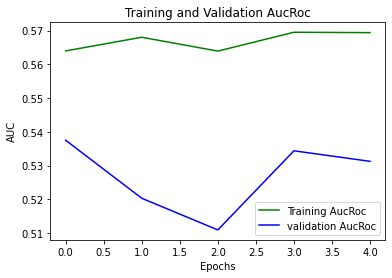

In [31]:
# For 60 days
seq_len = 60
batch_size = 128
n_epochs = 5

model_transformer('NASDAQ', seq_len, batch_size, n_epochs)

# For 30 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 61s 141ms/step - loss: 0.6544 - acc: 0.5706 - auc_17: 0.5706 - f1macro: 0.3628 - val_loss: 0.6832 - val_acc: 0.5320 - val_auc_17: 0.5320 - val_f1macro: 0.3467
Epoch 2/5
400/400 [==============================] - 56s 141ms/step - loss: 0.6544 - acc: 0.5706 - auc_17: 0.5706 - f1macro: 0.3628 - val_loss: 0.6474 - val_acc: 0.5797 - val_auc_17: 0.5797 - val_f1macro: 0.3664
Epoch 3/5
400/400 [==============================] - 56s 141ms/step - loss: 0.6520 - acc: 0.5739 - auc_17: 0.5739 - f1macro: 0.3642 - val_loss: 0.6805 - val_acc: 0.5359 - val_auc_17: 0.5359 - val_f1macro: 0.3484
Epoch 4/5
400/400 [==============================] - 57s 141ms/step - loss: 0.6543 - acc: 0.5710 - auc_17: 0.5710 - f1macro: 0.3631 - val_loss: 0.6930 - val_acc: 0.5188 - val_auc_17: 0.5188 - val_f1macro: 0.3410
Epoch 5/5
7/7 [==============================] - 0s 7ms/step
accuracy: 0.5804878048780487
MAE: 0.4195121951219512
F1: 0.7345679012345678
Area under Curve:  0.5


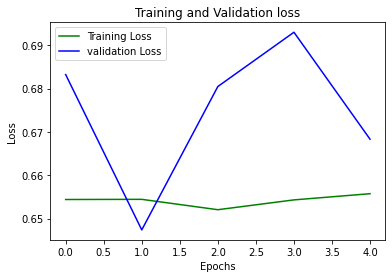

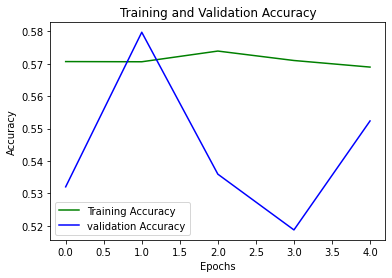

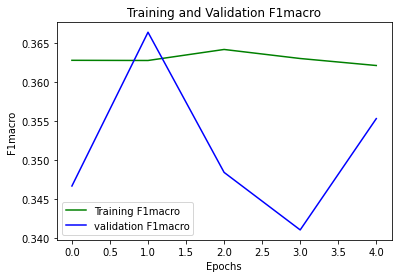

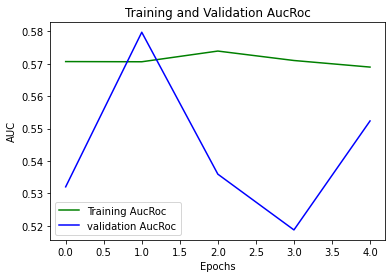

In [32]:
# For 30 days
seq_len = 30
batch_size = 128
n_epochs = 5

model_transformer('NASDAQ', seq_len, batch_size, n_epochs)

# For 20 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 60s 141ms/step - loss: 0.6527 - acc: 0.5728 - auc_18: 0.5728 - f1macro: 0.3637 - val_loss: 0.6711 - val_acc: 0.5492 - val_auc_18: 0.5492 - val_f1macro: 0.3543
Epoch 2/5
400/400 [==============================] - 57s 142ms/step - loss: 0.6560 - acc: 0.5686 - auc_18: 0.5686 - f1macro: 0.3620 - val_loss: 0.6731 - val_acc: 0.5461 - val_auc_18: 0.5461 - val_f1macro: 0.3527
Epoch 3/5
400/400 [==============================] - 56s 141ms/step - loss: 0.6541 - acc: 0.5710 - auc_18: 0.5710 - f1macro: 0.3630 - val_loss: 0.6741 - val_acc: 0.5437 - val_auc_18: 0.5437 - val_f1macro: 0.3513
Epoch 4/5
400/400 [==============================] - 56s 141ms/step - loss: 0.6539 - acc: 0.5713 - auc_18: 0.5713 - f1macro: 0.3631 - val_loss: 0.6845 - val_acc: 0.5305 - val_auc_18: 0.5305 - val_f1macro: 0.3461
Epoch 5/5
7/7 [==============================] - 0s 6ms/step
accuracy: 0.5804878048780487
MAE: 0.4195121951219512
F1: 0.7345679012345678
Area under Curve:  0.5


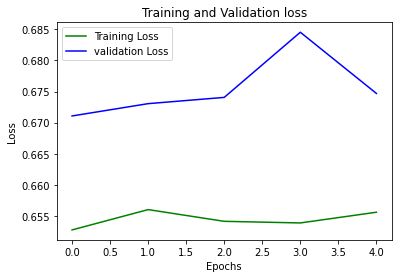

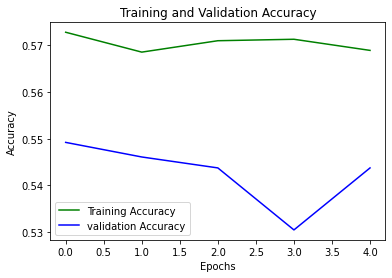

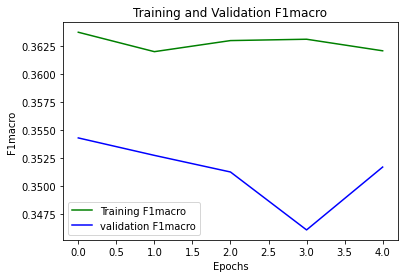

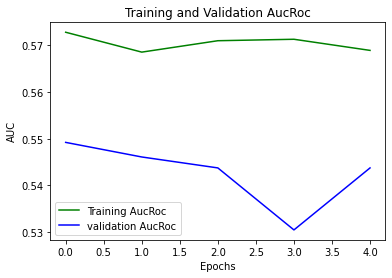

In [33]:
# For 20 days
seq_len = 20
batch_size = 128
n_epochs = 5

model_transformer('NASDAQ', seq_len, batch_size, n_epochs)

# For 10 Days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


400/400 [==============================] - 60s 139ms/step - loss: 0.6545 - acc: 0.5705 - auc_19: 0.5705 - f1macro: 0.3627 - val_loss: 0.6798 - val_acc: 0.5367 - val_auc_19: 0.5367 - val_f1macro: 0.3487
Epoch 2/5
400/400 [==============================] - 56s 140ms/step - loss: 0.6532 - acc: 0.5722 - auc_19: 0.5722 - f1macro: 0.3635 - val_loss: 0.6642 - val_acc: 0.5578 - val_auc_19: 0.5578 - val_f1macro: 0.3576
Epoch 3/5
400/400 [==============================] - 56s 139ms/step - loss: 0.6547 - acc: 0.5703 - auc_19: 0.5703 - f1macro: 0.3627 - val_loss: 0.6934 - val_acc: 0.5180 - val_auc_19: 0.5180 - val_f1macro: 0.3406
Epoch 4/5
400/400 [==============================] - 55s 138ms/step - loss: 0.6549 - acc: 0.5701 - auc_19: 0.5701 - f1macro: 0.3626 - val_loss: 0.6834 - val_acc: 0.5312 - val_auc_19: 0.5312 - val_f1macro: 0.3460
Epoch 5/5
7/7 [==============================] - 0s 5ms/step
accuracy: 0.5804878048780487
MAE: 0.4195121951219512
F1: 0.7345679012345678
Area under Curve:  0.5


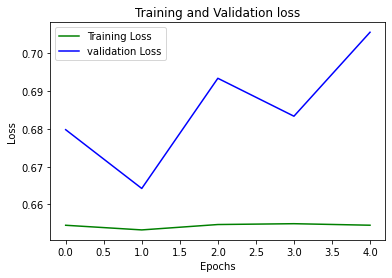

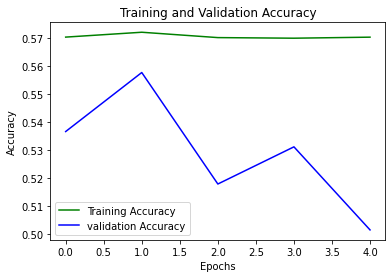

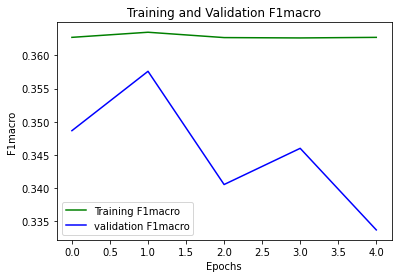

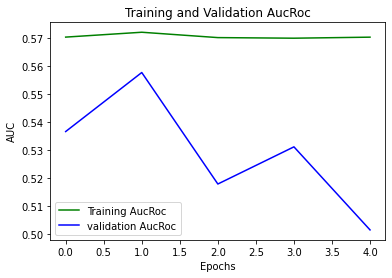

In [34]:
# For 10 days
seq_len = 10
batch_size = 128
n_epochs = 5

model_transformer('NASDAQ', seq_len, batch_size, n_epochs)